In [1]:
import pandas as pd
import seaborn as sns
from functools import reduce
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [2]:
happiness_report=pd.read_excel('WHR20_DataForFigure2.1.xls')
hdi=pd.read_csv('Human Development Index (HDI).csv')
hief_data=pd.read_csv('HIEF_data.csv')

schooling_years=pd.read_csv('Expected years of schooling (years).csv')
exports_imports=pd.read_csv('Exports and imports (% of GDP).csv')
gender_development=pd.read_csv('Gender Development Index (GDI).csv')
gni_per_capita=pd.read_csv('Gross national income (GNI) per capita (2011 PPP$).csv')
homicide_rate=pd.read_csv('Homicide rate (per 100,000 people).csv')
inequality=pd.read_csv('Inequality-adjusted HDI (IHDI).csv')
internet_users=pd.read_csv('Internet users, total (% of population).csv')
life_exp=pd.read_csv('Life expectancy at birth.csv')
population=pd.read_csv('Population, total (millions).csv')
skilled_labor=pd.read_csv('Skilled labour force (% of labour force).csv')
employment=pd.read_csv('Employment to population ratio (% ages 15 and older).csv')

data_frames=[schooling_years, exports_imports, gender_development, gni_per_capita, homicide_rate, inequality, 
            internet_users, life_exp, population, skilled_labor, employment]

In [3]:
hief_data=hief_data.loc[hief_data['Year']==2013]

In [4]:
def fix_csv(csv):
    csv.reset_index(inplace=True)
    new_headers=csv.iloc[0]
    csv.columns=new_headers
    csv.drop(index=0, inplace=True)
    csv=csv.loc[:, csv.columns.notnull()]
    csv=csv.loc[csv['2013']!='..'] # for some reason this also doesn't work inside the function
    #csv.dropna(axis=0, inplace=True)
    
def clean_columns(csv):
    #can't seem to get this to work in a function - gonna do it manually for now, will try to fix later
    csv=csv.loc[:, csv.columns.notnull()]

In [5]:
fix_csv(schooling_years)
fix_csv(exports_imports)
fix_csv(gender_development)
fix_csv(gni_per_capita)
fix_csv(homicide_rate)
fix_csv(inequality)
fix_csv(internet_users)
fix_csv(life_exp)
fix_csv(population)
fix_csv(skilled_labor)
fix_csv(employment)
fix_csv(hdi)

In [6]:
schooling_years=schooling_years.loc[:, schooling_years.columns.notnull()].loc[schooling_years['2013']!='..'].loc[schooling_years['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
exports_imports=exports_imports.loc[:, exports_imports.columns.notnull()].loc[exports_imports['2013']!='..'].loc[exports_imports['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gender_development=gender_development.loc[:, gender_development.columns.notnull()].loc[gender_development['2013']!='..'].loc[gender_development['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gni_per_capita=gni_per_capita.loc[:, gni_per_capita.columns.notnull()].loc[gni_per_capita['2013']!='..'].loc[gni_per_capita['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
homicide_rate=homicide_rate.loc[:, homicide_rate.columns.notnull()].loc[homicide_rate['2013']!='..'].loc[homicide_rate['2017']!='..'][['HDI Rank (2018)', 'Country', '2013', '2017']]
inequality=inequality.loc[:, inequality.columns.notnull()].loc[inequality['2013']!='..'].loc[inequality['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
internet_users=internet_users.loc[:, internet_users.columns.notnull()].loc[internet_users['2013']!='..'].loc[internet_users['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
life_exp=life_exp.loc[:, life_exp.columns.notnull()].loc[life_exp['2013']!='..'].loc[life_exp['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
population=population.loc[:, population.columns.notnull()].loc[population['2013']!='..'].loc[population['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
skilled_labor=skilled_labor.loc[:, skilled_labor.columns.notnull()].loc[skilled_labor['2013']!='..'].loc[skilled_labor['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
employment=employment.loc[:, employment.columns.notnull()].loc[employment['2013']!='..'].loc[employment['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]

In [17]:
schooling_years.rename(columns={'2013':'2013sy', '2018':'2018sy'}, inplace=True)
exports_imports.rename(columns={'2013':'2013ei', '2018':'2018ei'}, inplace=True)     
gender_development.rename(columns={'2013':'2013gd', '2018':'2018gd'}, inplace=True)
gni_per_capita.rename(columns={'2013':'2013gni', '2018':'2018gni'}, inplace=True)
inequality.rename(columns={'2013':'2013ineq', '2018':'2018ineq'}, inplace=True)
internet_users.rename(columns={'2013':'2013iu', '2018':'2018iu'}, inplace=True)
life_exp.rename(columns={'2013':'2013le', '2018':'2018le'}, inplace=True)
population.rename(columns={'2013':'2013p', '2018':'2018p'}, inplace=True)
skilled_labor.rename(columns={'2013':'2013sl', '2018':'2018sl'}, inplace=True)
employment.rename(columns={'2013':'2013emp', '2018':'2018emp'}, inplace=True)
homicide_rate.rename(columns={'2013':'2013h', '2017':'2018h'}, inplace=True)
#There is no data for 2018 in homicide_rate so I think it makes the most sense to just use 2017 for 2018

In [8]:
hdi=hdi[['Country', '2013', '2018']]

In [29]:
hief_data=hief_data[['Country', 'EFindex']]
happiness_report=happiness_report[['Country name', 'Ladder score']]

In [10]:
hdi_w_hief=hdi.merge(hief_data, how='outer')

In [11]:
hdi_w_hief

,Country,2013,2018,EFindex
0,Afghanistan,0.485,0.496,0.763
1,Albania,0.781,0.791,0.139
2,Algeria,0.746,0.759,0.372
3,Andorra,0.846,0.857,NaN
4,Angola,0.547,0.574,0.779
5,Antigua and Barbuda,0.767,0.776,NaN
6,Argentina,0.824,0.830,0.158
7,Armenia,0.743,0.760,0.045
8,Australia,0.926,0.938,0.276
9,Austria,0.896,0.914,0.248


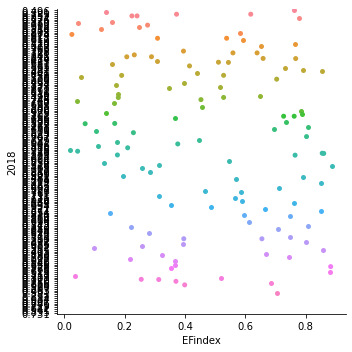

In [12]:
sns.catplot(x='EFindex', y='2018', data=hdi_w_hief)
#this actually suggests very little correlation bw the two variables

In [18]:
exports_imports

,HDI Rank (2018),Country,2013ei,2018ei
2,69,Albania,75.9,77.3
6,48,Argentina,29.3,30.8
7,81,Armenia,76.6,90.4
8,6,Australia,41.2,43.0
9,20,Austria,104.1,105.5
10,87,Azerbaijan,74.7,92.0
12,45,Bahrain,191.9,159.2
13,135,Bangladesh,46.3,38.2
15,50,Belarus,119.8,139.3
16,17,Belgium,162.2,175.6


In [35]:
schooling_years.merge(exports_imports, how='outer').merge(gender_development, how='outer').merge(gni_per_capita, 
    how='outer').merge(homicide_rate, how='outer').merge(inequality, how='outer').merge(internet_users, how='outer'
    ).merge(life_exp, how='outer').merge(population, how='outer').merge(skilled_labor, how='outer'
    ).merge(employment, how='outer').merge(hdi_w_hief, how='outer').merge(happiness_report, how='outer', left_on=
                                'Country', right_on='Country name').drop(columns={'Country name'})


,HDI Rank (2018),Country,2013sy,2018sy,2013ei,2018ei,2013gd,2018gd,2013gni,2018gni,2013h,2018h,2013ineq,2018ineq,2013iu,2018iu,2013le,2018le,2013p,2018p,2013sl,2018sl,2013emp,2018emp,2013,2018,EFindex,Ladder score
0,170,Afghanistan,10.2,10.1,NaN,NaN,0.707,0.723,1814,1746,NaN,NaN,NaN,NaN,NaN,NaN,62.5,64.5,32.3,37.2,NaN,NaN,63.2,64.9,0.485,0.496,0.763,2.5669
1,69,Albania,15.4,15.2,75.9,77.3,0.967,0.971,10669,12300,4.2,2.3,0.676,0.705,NaN,NaN,77.6,78.5,2.9,2.9,NaN,NaN,45.1,48.3,0.781,0.791,0.139,4.8827
2,82,Algeria,14.3,14.7,NaN,NaN,0.844,0.865,12946,13639,NaN,NaN,NaN,NaN,22.5,59.6,75.7,76.7,38.1,42.2,NaN,NaN,39.4,36.3,0.746,0.759,0.372,5.0051
3,36,Andorra,13.1,13.3,NaN,NaN,NaN,NaN,42376,48641,NaN,NaN,NaN,NaN,NaN,NaN,81.2,81.8,0.1,0.1,NaN,NaN,NaN,NaN,0.846,0.857,NaN,NaN
4,149,Angola,10.3,11.8,NaN,NaN,NaN,NaN,6294,5555,NaN,NaN,0.307,0.392,NaN,NaN,58.1,60.8,26.0,30.8,NaN,NaN,72.1,72.0,0.547,0.574,0.779,NaN
5,74,Antigua and Barbuda,12.8,12.5,NaN,NaN,NaN,NaN,19276,22201,NaN,NaN,NaN,NaN,NaN,NaN,76.2,76.9,0.1,0.1,NaN,NaN,NaN,NaN,0.767,0.776,NaN,NaN
6,48,Argentina,17.1,17.6,29.3,30.8,0.991,0.988,19228,17611,NaN,NaN,0.694,0.714,NaN,NaN,75.8,76.5,42.2,44.4,61.8,65.8,56.1,54.8,0.824,0.830,0.158,5.9747
7,81,Armenia,13.1,13.2,76.6,90.4,0.970,0.972,8169,9277,2.2,2.4,0.667,0.685,NaN,NaN,74.1,74.9,2.9,3.0,NaN,NaN,50.9,48.4,0.743,0.760,0.045,4.6768
8,6,Australia,20.4,22.1,41.2,43.0,0.974,0.975,42201,44097,1.1,0.8,0.854,0.862,NaN,NaN,82.5,83.3,23.3,24.9,NaN,NaN,61.3,61.5,0.926,0.938,0.276,7.2228
9,20,Austria,15.8,16.3,104.1,105.5,0.962,0.963,44420,46231,NaN,NaN,0.832,0.843,80.6,87.7,81.0,81.4,8.6,8.9,85.0,87.4,57.2,57.3,0.896,0.914,0.248,7.2942


In [30]:
happiness_report

,Country name,Ladder score
0,Finland,7.8087
1,Denmark,7.6456
2,Switzerland,7.5599
3,Iceland,7.5045
4,Norway,7.4880
5,Netherlands,7.4489
6,Sweden,7.3535
7,New Zealand,7.2996
8,Austria,7.2942
9,Luxembourg,7.2375
